# Notebook to calculate Statistics#

### Import the libraries###

In [265]:
import json
import zipfile
import os
import sys
import io
from ast import literal_eval
import pandas as pd
from itertools import chain
from itertools import groupby
import unicodedata
import numpy as np
import collections

from string import punctuation
translator = str.maketrans('','',punctuation) 

### Define all the necessary classes and functions###

In [306]:
class repository: 
    def __init__(self, policy, title, chapter, section, article):
        self.policy = policy
        self.title = title
        self.chapter = chapter
        self.section = section
        self.article = article
        
        
    def __repr__(self): #how to print the repository to the console
        return 'policy:' + self.policy + ' title:' + self.title + ' chapter:' + self.chapter + ' section:' + self.section + ' article:' + self.article          
   
    @classmethod
    def from_repository_name(cls, rep_str):                #2nd initializer that creates a repository object directly from a repository string e.g 'EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03.txt'
        folder_parts = rep_str.split('_')                  #split the string at '_' into parts 
        policy = folder_parts[0] + '_' + folder_parts[1]   #we only want to split at every 2nd '_', so merge the 1. and 2., 3. and 4. again 
        if folder_parts[2] in  ['front', 'Whereas']:       #exeption for the 'whereas' and 'front'
            title = 'front'
            chapter = 'None'
            section = 'None'
            article = 'None'
        else:
            title = folder_parts[2] + '_' + folder_parts[3]
            chapter = folder_parts[4] + '_' + folder_parts[5]
            section = folder_parts[6] + '_' + folder_parts[7]
            article = folder_parts[8] + '_' + folder_parts[9]
        
        return cls(policy,title, chapter, section, article)  #return a repository with the previously defined attributes
    
    def match(self, other):            #checks if the search-criteria defined in repository 'other' is matching the the current repository                                                
        self_value_set = set([x for x in list(self.__dict__.values()) if x != 'None']) #creates a set of all the attributes ignoring 'None'    
        other_value_set = set([x for x in list(other.__dict__.values()) if x != 'None'])
        

        return set(other_value_set).issubset(self_value_set) #returns True if the attributes of the search-criteria is a subset of the attributes of the current directory (=match)
    
class token:
    def __init__(self, start, stop, text):
        self.start = start
        self.stop = stop
        self.text = text
        #self.tag_count = tag_count
        
    def __repr__(self):
        return 'start:' + str(self.start) + ' stop:' + str(self.stop) + ' text:' + self.text
        
    
class tag:
    def __init__(self, class_, type_, tag_, start, stop, text, tokens, rep):
        self.class_ = class_
        self.type_ = type_
        self.tag_ = tag_
        self.start = start
        self.stop = stop
        self.text = text
        self.tokens = tokens
        self.rep = rep
        
        
    def __eq__(self, other): 
        if not isinstance(other, tag):
            # don't attempt to compare against unrelated types
            return NotImplemented

        return self.class_ == other.class_ and self.type_ == other.type_ and self.tag_ == other.tag_ and self.start == other.start and self.stop == other.stop
    
    def __repr__(self): #for debugging purpose, defines how object is printed
        return "class:" + self.class_ + " type:" + self.type_ + " tag:" + self.tag_ + " start:" + str(self.start) + " stop:" + str(self.stop) + " text:" + self.text + '\n'

            
    
class Evaluator:
    
    def __init__(self, df):
        self.df = df
        
        
    def _get_iterator_all(self): #returns a iterator of all the tags present in the dataframe
        
        return chain.from_iterable(self.df['Tags'])
        
        
    def _get_iterator_condition(self, conditional_rep): #returns a list for all the tags that match the attributes defined in the 'conditional_rep' 
  
        iterator = chain.from_iterable(self.df['Tags'])
        return [x for x in iterator if type(x)!= str and x.rep.match(conditional_rep) == True]
        
     
    
    def get_list_old(self, article, item, value):
        iterator = self._get_iterator(article)
        if item == 'class':
            return [x for x in iterator if type(x)!= str and x.class_ == value]
        if item == 'type':
            return [x for x in iterator if type(x)!= str and x.type_ == value]
        if item == 'tag':
            return [x for x in iterator if type(x)!= str and x.tag_ == value]
        
    def get_tag_list(self, conditional_rep, item, value):
       
        iterator = self._get_iterator_condition(conditional_rep)
        
        if item == 'None' and value == 'None':
            return [x for x in iterator if type(x)!= str ]
        if item == 'class':
            return [x for x in iterator if type(x)!= str and x.class_ == value]
        if item == 'type':
            return [x for x in iterator if type(x)!= str and x.type_ == value]
        if item == 'tag':
            return [x for x in iterator if type(x)!= str and x.tag_ == value]
        
    
    def get_span_distro(self, conditional_rep, item, value, return_format):
        
        tag_list = self.get_tag_list(conditional_rep, item, value)
        len_list = [(x.stop - x.start) for x in tag_list]
        len_dict = collections.Counter(len_list)
        
        if return_format == 'dict':
            return dict(sorted(len_dict.items(), key=lambda item: item[1], reverse=True))
            
        
        if return_format == 'list':
            distro_list = []
            for i in range(1,max(len_list)+1):
                distro_list.append(len_list.count(i))
            return distro_list
                      
     
    def get_frequency(self, conditional_rep, item, value):
        return len(self.get_tag_list(conditional_rep, item, value))
    
    
    def get_token_count(self, conditional_rep, item, value):
        tag_list = self.get_tag_list(conditional_rep, item, value) #get the taglist of all the tag that match search criteria
        token_iterator = chain.from_iterable([x.tokens for x in tag_list])
        return len(list(token_iterator)) #retrieve all the tokens from the tag list and create a iterator (since the list contains sublists)
    
    def most_frequent_tokens(self, conditional_rep, item, value):
        tag_list = self.get_tag_list(conditional_rep, item, value) #get the taglist of all the tag that match search criteria
        token_iterator = chain.from_iterable([x.tokens for x in tag_list]) #retrieve all the tokens from the tag list and create a iterator (since the list contains sublists)
        token_counter_dict = collections.Counter([x.text for x in token_iterator]) #get a list the text of the token, count the different elements and create a dict
        return dict(sorted(token_counter_dict.items(), key=lambda item: item[1], reverse=True))  #sort the dict by counts
        
        
        return 0

            
         
        
        
        
    
      
  
          
        

### Helper funtions###

In [307]:
def normalize_and_replace_text(sentence):
    doc = unicodedata.normalize("NFKD", sentence)
    doc = doc.replace('\r', '').replace('\n', ' ')

    
    return doc

def clean_text(doc):
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    no_numbers = [w if not w.isdigit() else '#' for w in words]

    return no_numbers

def get_repository_names(folder_name):
    folder_parts = folder_name.split('_')
    policy = folder_parts[0] + '_' + folder_parts[1]
    title = folder_parts[2] + '_' + folder_parts[3]
    chapter = folder_parts[4] + '_' + folder_parts[5]
    section = folder_parts[6] + '_' + folder_parts[7]
    article = folder_parts[8] + '_' + folder_parts[9]
    
    
     
    return policy, title, chapter, section, article



### Create the DataFrame ###

In [308]:
stat_df = pd.DataFrame(columns = ['Policy', 'Text','Tags']) #create the initial dataframe
tagsets = ['Policydesigncharacteristics','Technologyandapplicationspecificity','Instrumenttypes']


In [309]:
path = '/home/kueddelmaier/Downloads/full_project_curated_json/curation'  #Datapath
subdirs = [o for o in os.listdir(path) if os.path.isdir(path)] #identify all the subdirs which correspond to different articles
os.chdir(path)

In [310]:
for subdir in subdirs:
   
    try:
        archive = zipfile.ZipFile(os.path.join(subdir, str(os.listdir(subdir)[0])), 'r') #decode compressed json in zip file
        json_file_byte = archive.read('CURATION_USER.json')      #this is a binary
        
        json_file_byte_decode = json_file_byte.decode('utf8')    #decode to json
    
        data = json.loads(json_file_byte_decode)
    
    except:
        stat_df = stat_df.append(pd.Series([subdir, 'error', 'error'], index=stat_df.columns ), ignore_index=True) #append error column if cannot read data

        
    else:
        taglist = []      #create epty list holding all the tags of the aragraph (= article)
        rep = repository.from_repository_name(subdir[0:-4])  #directory name in string format
        sentence = data['_referenced_fss']['1']['sofaString']  #raw text of the paragraph
        all_tokens = data['_views']['_InitialView']['Token']
        all_tokens[0]['begin'] = 0                            #the first token is missing the beginning
        sentence_normalized = normalize_and_replace_text(sentence) 
        
        for category in data['_views']['_InitialView']:  #loop trough the custom layers
  
            if category in tagsets:
                    
                for annotation in data['_views']['_InitialView'][category]: #loop trough all the tags
                    
                    type_ = list(annotation.keys())[-1]     #this part handles empty annotations. The last entry of the dict usually contains the type and the tag.
                                                            #for empty tags, the last entry is a integer
                    if type(type_) != str:                  
                        type_ = ''
                    tag_ = list(annotation.values())[-1]
                    if type(tag_) != str:
                        tag_ = ''
                        
                    start = annotation['begin']
                    stop = annotation['end']
                    tokens = [token(x['begin'], x['end'], sentence[x['begin']:x['end']]) for x in all_tokens if  x['begin'] >= start and x['end'] <= stop]
                    taglist.append(tag(category, type_, tag_ , start ,stop , sentence[start:stop], tokens, rep))
                    
        stat_df = stat_df.append(pd.Series([subdir[0:-4], sentence ,taglist], index=stat_df.columns ), ignore_index=True)     
stat_df['tokens cleaned'] = stat_df['Text'].apply(clean_text)    

## Small Tutorial



### Classes and Dataframe

All the information is now stored in a dataframe called "stat_df" containing the string of the directory path, the raw text and the tags (the cleaned tokens are not important for now):

In [311]:
stat_df.head()

,Policy,Text,Tags,tokens cleaned
0,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,Article 7\r\nJoint projects between Member Sta...,[class:Policydesigncharacteristics type:Actor ...,"[article, #, joint, projects, between, member,..."
1,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,Article 14\r\nAdjustment of M0 and TM0 values\...,[class:Instrumenttypes type:InstrumentType tag...,"[article, #, adjustment, of, m0, and, tm0, val..."
2,EU_32019R0631_Title_0_Chapter_0_Section_0_Arti...,Article 16\r\nCommittee procedure\r\n1. The ...,[class:Policydesigncharacteristics type:Actor ...,"[article, #, committee, procedure, #, the, com..."
3,EU_32008R1099_Title_0_Chapter_0_Section_0_Arti...,Article 9\r\nRenewable energy statistics and f...,[class:Instrumenttypes type:InstrumentType tag...,"[article, #, renewable, energy, statistics, an..."
4,EU_32009L0028_Title_0_Chapter_0_Section_0_Arti...,Article 12\r\nCapacity increases\r\nFor the pu...,[class:Technologyandapplicationspecificity typ...,"[article, #, capacity, increases, for, the, pu..."


The tags of each paragraph are stored in list:

In [312]:
stat_df['Tags'][2]

[class:Policydesigncharacteristics type:Actor tag:Addressee_default start:12 stop:21 text:Committee,
 class:Policydesigncharacteristics type:Actor tag:Authority_default start:42 stop:52 text:Commission,
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:78 stop:102 text:Climate Change Committee,
 class:Policydesigncharacteristics type:Reference tag:Ref_OtherPolicy start:148 stop:173 text:Regulation (EU) 2018/1999,
 class:Policydesigncharacteristics type:Actor tag:Authority_legislative start:181 stop:200 text:European Parliament,
 class:Policydesigncharacteristics type:Actor tag:Authority_legislative start:212 stop:219 text:Council,
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:231 stop:240 text:committee,
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:252 stop:261 text:committee,
 class:Policydesigncharacteristics type:Reference tag:Ref_OtherPolicy start:284 stop:311 text:Regulation (EU) No 182/2011,
 class:P

Each tag has a class, type, tag, start, stop and the text (raw) 

In [313]:
stat_df['Tags'][2][2]

class:Policydesigncharacteristics type:Actor tag:Addressee_default start:78 stop:102 text:Climate Change Committee

Further has each tag a repository and a list of all the tokens

In [314]:
stat_df['Tags'][2][2].rep

policy:EU_32019R0631 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_16

In [315]:
stat_df['Tags'][2][2].tokens

[start:78 stop:85 text:Climate,
 start:86 stop:92 text:Change,
 start:93 stop:102 text:Committee]

Repository's can be created trought the normal constructor **init**(self, policy, title, chapter, section, article) , or trough the classmethod **from_repository_name**(cls, rep_str), taking only a big string of the repository name. 

### Conditional Repository

The repository class can be used to create conditional repositorys, which are usefull to search in all the paragraphs matching a certain condition. Let's go on and create a test repository:

In [316]:
test_dir = repository.from_repository_name("EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03")
test_dir

policy:EU_32008R1099 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_03

Let's now create a conditional repository. On each hirarchy, I can either match a certain name or I can match all the names by inserting 'None'. Simply speaking, we match all repositorys with the attributes given other than 'None. Let's assume I want to match all the tags in 'EU_32008R1099' I would create a repository like this:

In [317]:
test_dir = repository(policy = 'EU_32008R1099', title = 'None', chapter = 'None', section = 'None', article = 'None')

or simply

In [318]:
test_dir = repository('EU_32008R1099', 'None', 'None', 'None', 'None')

If I want to match all the tags that are stored in the first article in all the policy's, titles, chapters and sections

In [319]:
test_dir = repository('None', 'None', 'None', 'None', 'Article_01')

### Class Evaluator and evaluation functions

All the funtions calculating statistics are contained the class "evaluator", it's only class member is the dataframe:

In [320]:
test_evaluator = Evaluator(stat_df)

The most important funtion is the member function get_tag_list(self, conditional_rep, item, value). This functions takes a conditional repository (explained before), a item which can be either 'class, 'type' or 'tag' and a value. E.g item = 'class' and value = 'Policydesigncharacteristics' or item = 'type and value ='Compliance' and item = 'tag' and value = 'Form_monitoring'. 

The function returns a list of all the tags in all the paragraphs matching the conditional repository and matching the item and value given. E.g I want to match all the tags of type 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [321]:
test_dir = repository('EU_32008R1099', 'None', 'None', 'None', 'None')
test_evaluator.get_tag_list(item = 'class', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

[class:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:21 stop:38 text:energy statistics,
 class:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:43 stop:78 text:final energy consumption statistics,
 class:Policydesigncharacteristics type:Objective tag:Objective_QualIntention_noCCM start:100 stop:181 text:improving the quality of renewable energy and final energy consumption statistics,
 class:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:208 text:Commission (Eurostat),
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:208 text:Commission (Eurostat),
 class:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:197 text:Commission,
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:197 text:Commission,
 class:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:199 stop:207 text:Eurostat,
 class:Policydesig

If I don't want to specify the item and the value, so match all the tags that match the conditional repository, I can put 'None':

In [322]:
test_evaluator.get_tag_list(item = 'None', value = 'None', conditional_rep = test_dir)

[class:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:1343 stop:1363 text:regulatory procedure,
 class:Instrumenttypes type:InstrumentType tag:RegulatoryInstr start:1525 stop:1545 text:regulatory procedure,
 class:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:21 stop:38 text:energy statistics,
 class:Policydesigncharacteristics type:Compliance tag:Form_monitoring start:43 stop:78 text:final energy consumption statistics,
 class:Policydesigncharacteristics type:Objective tag:Objective_QualIntention_noCCM start:100 stop:181 text:improving the quality of renewable energy and final energy consumption statistics,
 class:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:208 text:Commission (Eurostat),
 class:Policydesigncharacteristics type:Actor tag:Addressee_default start:187 stop:208 text:Commission (Eurostat),
 class:Policydesigncharacteristics type:Actor tag:Authority_monitoring start:187 stop:197 text:Commission,
 clas

All the other member functions are based on the Evaluator.get_tag_list member function, they also take the same inputs. 

get_span_distro(self, conditional_rep, item, value, return_format) return the distribution of spans of a tag_list either in dict{span:count} or list format:

In [323]:
test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'dict')

{10: 33,
 19: 19,
 20: 16,
 8: 14,
 13: 14,
 17: 13,
 21: 12,
 6: 12,
 11: 11,
 9: 9,
 4: 8,
 18: 8,
 7: 7,
 35: 6,
 27: 6,
 15: 6,
 12: 6,
 16: 4,
 25: 4,
 5: 4,
 22: 3,
 31: 3,
 23: 2,
 14: 2,
 24: 2,
 29: 2,
 42: 2,
 28: 2,
 81: 1,
 3: 1,
 58: 1,
 34: 1,
 59: 1,
 99: 1,
 72: 1,
 76: 1,
 30: 1,
 108: 1,
 33: 1,
 45: 1,
 36: 1}

In [324]:
test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'list')

[0,
 0,
 1,
 8,
 4,
 12,
 7,
 14,
 9,
 33,
 11,
 6,
 14,
 2,
 6,
 4,
 13,
 8,
 19,
 16,
 12,
 3,
 2,
 2,
 4,
 0,
 6,
 2,
 2,
 1,
 3,
 0,
 1,
 1,
 6,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

This span ditro can also be plottet:

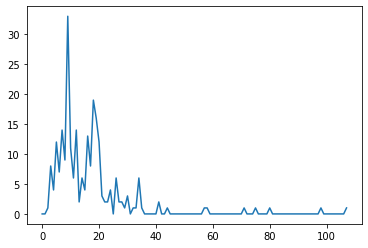

In [328]:
import matplotlib.pyplot as plt
plt.plot(test_evaluator.get_span_distro(item = 'None', value = 'None', conditional_rep = test_dir, return_format = 'list'))
plt.show()

get_frequency(self, article, item, value) returns the lenght of all the tags in the tag_list. Can be used to retrieve the amount of tags matching a certain condition. E.g all the tags of class 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [325]:
test_evaluator.get_frequency(item = 'class', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

203

get_token_count(self, conditional_rep, item, value) returns the amount of tokens in the tag_list:

In [326]:
test_evaluator.get_token_count(item = 'class', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

513

most_frequent_tokens(self, conditional_rep, item, value) returns a dict of all the most frequent tokens of a tag_list

In [327]:
test_evaluator.most_frequent_tokens(item = 'class', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

{'statistics': 54,
 'energy': 27,
 'Commission': 24,
 'Eurostat': 19,
 '/': 15,
 'the': 14,
 'national': 14,
 'and': 12,
 '(': 12,
 ')': 12,
 'Member': 12,
 'of': 11,
 'States': 11,
 'EC': 9,
 'data': 8,
 'final': 7,
 'consumption': 7,
 'renewable': 6,
 'Community': 6,
 'nuclear': 6,
 'Decision': 6,
 'annual': 5,
 'Regulation': 4,
 'No': 4,
 '\xa0': 4,
 'following': 4,
 'reported': 4,
 'monthly': 4,
 'studies': 3,
 '322': 3,
 '97': 3,
 'EUROPEAN': 3,
 'COUNCIL': 3,
 'Treaty': 3,
 '1999': 3,
 '468': 3,
 'months': 3,
 'year': 3,
 'for': 3,
 'monitoring': 3,
 'gas': 3,
 'statistical': 3,
 'producers': 3,
 'traders': 3,
 'distributors': 3,
 'transporters': 3,
 'importers': 3,
 'exporters': 3,
 'pilot': 2,
 'cost-benefit': 2,
 'analyses': 2,
 'reporting': 2,
 'PARLIAMENT': 2,
 'European': 2,
 '20th': 2,
 'day': 2,
 'its': 2,
 'publication': 2,
 'from': 2,
 '2009': 2,
 'period': 2,
 'Committee': 2,
 '2005': 2,
 '166': 2,
 'mechanism': 2,
 'Kyoto': 2,
 'Protocol': 2,
 'users': 2,
 'informatio